# Code Comment Categorization


### Yiğit Sert
### Hasan Ali Özen
### Serhat Karaca

<br>
This project involves the implementation of a text classification pipeline that processes user comments, converts them into machine-readable formats, and trains machine learning models to predict predefined categories. The system is designed to evaluate the performance of different models and vectorization techniques to determine the most effective approach for text classification.


## Importing Required Libraries

In this section, we import libraries for:

- **Data handling**: `pandas`, `numpy`
- **Text preprocessing**: `nltk` for stopword removal, stemming, and lemmatization
- **Machine learning**: Libraries from `sklearn` for vectorization, model training, and evaluation
- **Visualization**: `matplotlib` for plotting confusion matrices
- **Model saving/loading**: `joblib` for serialization of trained models


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import joblib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime
from gensim.models import Word2Vec
import nltk


## Downloading NLTK Data

To process the text data, we need to download specific language resources provided by **NLTK**:

- **Stopwords**: Commonly used words like "the", "is" which do not add value to text analysis.
- **WordNet**: A lexical database used for lemmatization.
- **OMW-1.4**: Extension for multilingual lemmatization.


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading the Dataset

We load the dataset from an Excel file. The following steps are performed:

1. **Check if the file exists**.
2. **Rename columns** for readability and select only the relevant columns.
3. **Drop rows** containing missing values.
4. **Display** the first few rows of the cleaned dataset.

https://www.sciencedirect.com/science/article/pii/S0952197623006693#tbl1


In [ ]:
# File path for the dataset
file_path = "Comment_categorization_corpus_final.xlsx"

# Check if the file exists
if not os.path.exists(file_path):
    print("File not found!")  # Print an error if file is missing
else:
    data = pd.read_excel(file_path)  # Load the dataset

# Clean up column names and rename them for easier handling
data.columns = data.columns.str.strip()
data = data[['#include "map_in_map.h"', 'Code']].rename(columns={
    '#include "map_in_map.h"': 'Comment',  # Rename comment column
    'Code': 'Category'                    # Rename category column
})

# Drop rows where data is missing
data = data.dropna()

# Display the first few rows for validation
print(data.head())


                                          Comment Category
0            - offsetof(struct bpf_array, value);     Code
1                 array->index_mask = index_mask;     Code
2  bpf_map_charge_move(&array->map.memory, &mem);     Code
3                   array->elem_size = elem_size;     Code
4                             return &array->map;     Code


## Text Cleaning Function

This function processes text data to prepare it for machine learning:

1. **Convert text to lowercase** for consistency.
2. **Remove numbers, special characters, and extra spaces**.
3. **Remove stopwords** using NLTK's stopword list.
4. Apply **lemmatization** (reduces words to their base form) and **stemming** (removes suffixes like "-ing").


In [ ]:
# Load the set of English stopwords
stop_words = set(stopwords.words('english'))
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function to clean a single text input
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabet characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # Stem words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# Apply the cleaning function to the comments column
data['Comment'] = data['Comment'].astype(str)  # Ensure the column is of type string
data['cleaned_comments'] = data['Comment'].apply(clean_text)  # Apply cleaning function

print("cleaned text data : ")
print(data.head())


                                          Comment Category  \
0            - offsetof(struct bpf_array, value);     Code   
1                 array->index_mask = index_mask;     Code   
2  bpf_map_charge_move(&array->map.memory, &mem);     Code   
3                   array->elem_size = elem_size;     Code   
4                             return &array->map;     Code   

                     cleaned_comments  
0        offsetofstruct bpfarray valu  
1            arrayindexmask indexmask  
2  bpfmapchargemovearraymapmemori mem  
3                    arrayelems elems  
4                     return arraymap  


## Feature Extraction

We use three techniques to convert text into numerical features:

1. **Bag-of-Words (BoW)**: Counts word occurrences.
2. **TF-IDF**: Considers the importance of words by normalizing frequencies.
3. **Word2Vec**: Generates word embeddings by training on the dataset.


In [ ]:
# Bag-of-Words (BoW) representation
vectorizer_bow = CountVectorizer(max_features=5000)  # Limit to top 5000 features
X_bow = vectorizer_bow.fit_transform(data['cleaned_comments'])

# TF-IDF representation
vectorizer_tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Include unigrams and bigrams
X_tfidf = vectorizer_tfidf.fit_transform(data['cleaned_comments'])

# Word2Vec representation
word2vec_model = Word2Vec(
    sentences=[comment.split() for comment in data['cleaned_comments']],
    vector_size=100, window=5, min_count=1, workers=4
)

# Convert comments to their Word2Vec representations
X_word2vec = np.array([
    np.mean([word2vec_model.wv[word] for word in comment.split() if word in word2vec_model.wv], axis=0)
    if any(word in word2vec_model.wv for word in comment.split())
    else np.zeros(word2vec_model.vector_size)
    for comment in data['cleaned_comments']
])
print("Bag-of-Words Representation :")
print(X_bow.toarray())
print("TF-IDF Representation :")
print(X_tfidf.toarray())
print("Word2Vec Representation :")
print(X_word2vec)


Bag-of-Words Representation :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
TF-IDF Representation :
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Word2Vec Representation :
[[ 1.77677095e-01  1.40970454e-01  1.96946740e-01 ... -3.63302976e-01
   3.22399408e-01  1.25078902e-01]
 [ 1.08172186e-02  2.24428326e-02  2.38627568e-02 ... -3.46193090e-02
   3.05804275e-02  1.37624107e-02]
 [ 9.44300927e-03  1.39471609e-02  2.42732354e-02 ... -2.33890563e-02
   3.66316698e-02  1.31245069e-02]
 ...
 [ 1.96992695e-01  2.59940475e-01  2.63684511e-01 ... -4.74947304e-01
   4.47845608e-01  2.06863880e-01]
 [ 3.08148321e-02  3.20876800e-02  3.77089418e-02 ... -5.57310767e-02
   5.90030514e-02  2.15470456e-02]
 [ 1.70471333e-03  6.50279690e-05  1.19901132e-02 ... -8.58536735e-03
   9.98489000e-03  5.19052614e-03]]


## Data Splitting

We divide the dataset into training and test sets:

1. **Training set**: Used to train the model (80%).
2. **Test set**: Used to evaluate the model (20%).


In [ ]:
# Selecting TF-IDF features for the model
X = X_tfidf
y = data['Category']  # Target labels

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset information
print("Shape of X (TF-IDF Features):", X.shape)
print("Shape of y (Target Labels):", y.shape)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

# category distribution
y_train_counts = y_train.value_counts()
y_test_counts = y_test.value_counts()
print("\nCategory distribution in training set:")
print(y_train_counts)
print("\nCategory distribution in test set:")
print(y_test_counts)

# examples from training data
print("\nSample training data (features and labels):")
for i in range(min(5, len(y_train))):
    print(f"Features: {X_train[i].toarray()[:5]} Label: {y_train.iloc[i]}")


Shape of X (TF-IDF Features): (10131, 5000)
Shape of y (Target Labels): (10131,)
Training set size: 8104
Test set size: 2027

Category distribution in training set:
Category
Functional-Inline    4205
Functional-Method    1486
Code                  603
Notice                525
Functional-Module     503
ToDo                  483
General               204
IDE                    93
Todo                    2
Name: count, dtype: int64

Category distribution in test set:
Category
Functional-Inline    1000
Functional-Method     356
Code                  173
Notice                156
ToDo                  153
Functional-Module     124
General                44
IDE                    20
Todo                    1
Name: count, dtype: int64

Sample training data (features and labels):
Features: [[0. 0. 0. ... 0. 0. 0.]] Label: Functional-Method
Features: [[0. 0. 0. ... 0. 0. 0.]] Label: IDE
Features: [[0. 0. 0. ... 0. 0. 0.]] Label: Code
Features: [[0. 0. 0. ... 0. 0. 0.]] Label: Functional-Method

## Model Training and Evaluation

We train three machine learning models and evaluate their performance:

1. **Logistic Regression**
2. **Naïve Bayes**
3. **Neural Networks (MLP)**


Training Logistic Regression...

Logistic Regression Performance:
Accuracy Score: 0.7030093734583128
Classification Report:
                    precision    recall  f1-score   support

             Code       0.83      0.22      0.35       173
Functional-Inline       0.64      0.97      0.77      1000
Functional-Method       0.87      0.54      0.67       356
Functional-Module       0.89      0.38      0.53       124
          General       0.92      0.75      0.82        44
              IDE       1.00      0.55      0.71        20
           Notice       0.92      0.23      0.37       156
             ToDo       0.97      0.61      0.75       153
             Todo       0.00      0.00      0.00         1

         accuracy                           0.70      2027
        macro avg       0.78      0.47      0.55      2027
     weighted avg       0.77      0.70      0.67      2027



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


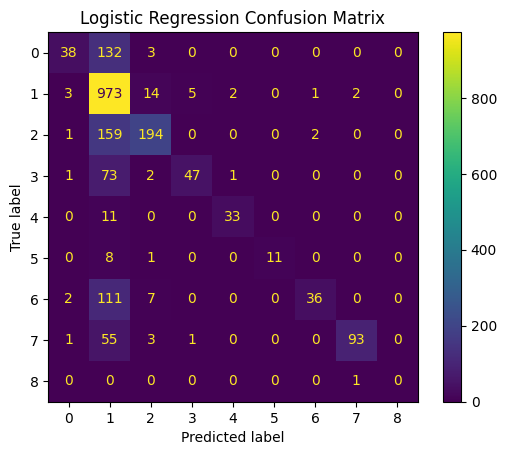

Training Naïve Bayes...

Naïve Bayes Performance:
Accuracy Score: 0.6201282683769117
Classification Report:
                    precision    recall  f1-score   support

             Code       1.00      0.12      0.21       173
Functional-Inline       0.57      0.99      0.73      1000
Functional-Method       0.85      0.40      0.54       356
Functional-Module       0.93      0.11      0.20       124
          General       0.95      0.48      0.64        44
              IDE       1.00      0.50      0.67        20
           Notice       0.86      0.08      0.14       156
             ToDo       0.94      0.31      0.46       153
             Todo       0.00      0.00      0.00         1

         accuracy                           0.62      2027
        macro avg       0.79      0.33      0.40      2027
     weighted avg       0.74      0.62      0.55      2027



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


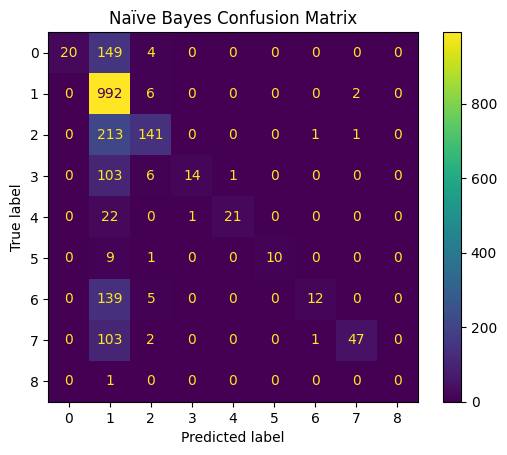

Training Neural Networks (MLP)...

Neural Networks (MLP) Performance:
Accuracy Score: 0.659595461272817
Classification Report:
                    precision    recall  f1-score   support

             Code       0.56      0.77      0.65       173
Functional-Inline       0.73      0.70      0.71      1000
Functional-Method       0.56      0.61      0.58       356
Functional-Module       0.61      0.54      0.57       124
          General       0.77      0.77      0.77        44
              IDE       0.74      0.85      0.79        20
           Notice       0.48      0.42      0.45       156
             ToDo       0.86      0.66      0.75       153
             Todo       0.00      0.00      0.00         1

         accuracy                           0.66      2027
        macro avg       0.59      0.59      0.59      2027
     weighted avg       0.67      0.66      0.66      2027



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


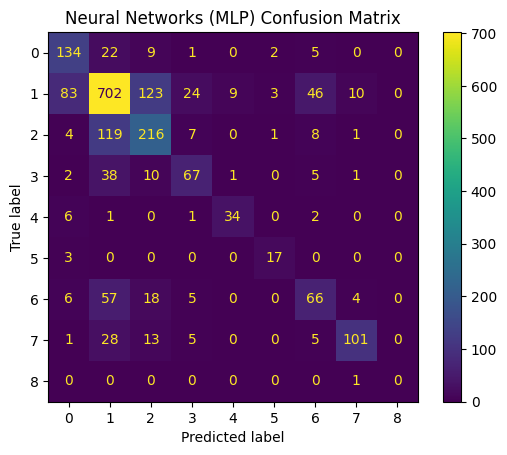

In [ ]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naïve Bayes': MultinomialNB(),
    'Neural Networks (MLP)': MLPClassifier(max_iter=1000)
}

# Train each model and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions on test data

    # Print evaluation metrics
    print(f"\n{model_name} Performance:")
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


## Saving Models and Vectorizers

Finally, we save the trained models and vectorizers for future use.


In [ ]:
# Timestamp to ensure unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save each model
for model_name, model in models.items():
    model_filename = f'{model_name.replace(" ", "_").lower()}_model_{timestamp}.pkl'
    joblib.dump(model, model_filename)

# Save vectorizers and Word2Vec model
joblib.dump(vectorizer_tfidf, f'tfidf_vectorizer_{timestamp}.pkl')
joblib.dump(vectorizer_bow, f'bow_vectorizer_{timestamp}.pkl')
joblib.dump(word2vec_model, f'word2vec_model_{timestamp}.pkl')


['word2vec_model_20241224_102721.pkl']

## References

Kostić, Marija, Vuk Batanović, and Boško Nikolić. "Monolingual, multilingual and cross-lingual code comment classification." Engineering Applications of Artificial Intelligence 124 (2023): 106485.
